## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Notebook Parameters

In [4]:

import os 

### parameters 

notebook_name = 'exp8_model_search_v2' # name of the notebook

## Generation of ground truth model 

model_name = 'test_models'
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (1000, 5000)
param_range = (0.05, 20)
param_multiplier_range = (0.5, 1.5)


## Simulation parameters 

simulation_time = 1000 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'lhs'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used

## Search parameters

o_random_seeds = list(range(1, 2))
parameter_random_seeds = list(range(1, 3))

    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
- 'random parameter': randomizes a x% of parameter values of the model
'''

''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp8_model_search_v2/


## Small Model Formulation

In [63]:
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

rr_solver = RoadrunnerSolver()

In [64]:

from models.Utils import *

### Generate the ground truth model

model_spec = ModelSpecification()
model_spec.generate_specifications(1, 1, 0, verbose=0)
print(model_spec)

A Species: ['A0']
B Species: ['B0']
C Species: ['C']
Regulations: [('A0', 'B0'), ('B0', 'C')]
Regulation Types: ['up', 'down']



In [65]:
model_build = model_spec.generate_network('model1', 
                                          (500,600),
                                          (1,2),
                                          (0.5, 1.5),
                                          1,
                                          1)

model_build.precompile()

Model States:  6
Model Parameters:  14
Model Reactions:  6


--- Antimony Model ---


model model1

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km + A0)
J2: B0p -> B0; J2_Vmax*B0p/(J2_Km + B0p)
J3: B0 -> B0p; (J3_Vmax+A0p*J3_Kw0)*B0/(J3_Km + B0)
J4: C -> Cp; J4_Vmax*C/(J4_Km*(1+B0p*J4_Kic0) + C)
J5: Cp -> C; J5_Vmax*Cp/(J5_Km + Cp)

# State variables in the system
A0p=0
A0=547
B0p=0
B0=551
C=100
Cp=0

# Parameters in the system
J0_Km=219.2842381948215
J0_Vmax=16.574861904030605
J1_Km=219.2842381948215
J1_Vmax=16.574861904030605
J2_Km=219.2842381948215
J2_Vmax=16.574861904030605
J3_Km=219.2842381948215
J3_Vmax=1.6574861904030604
J3_Kw0=0.12112486762353795
J4_Km=219.2842381948215
J4_Vmax=1.6574861904030604
J4_Kic0=0.12112486762353795
J5_Km=219.2842381948215
J5_Vmax=16.574861904030605

# Other variables in the system


end




In [66]:
print(model_build.get_parameters())

{'J0_Km': 219.2842381948215, 'J0_Vmax': 16.574861904030605, 'J1_Km': 219.2842381948215, 'J1_Vmax': 16.574861904030605, 'J2_Km': 219.2842381948215, 'J2_Vmax': 16.574861904030605, 'J3_Km': 219.2842381948215, 'J3_Vmax': 1.6574861904030604, 'J3_Kw0': 0.12112486762353795, 'J4_Km': 219.2842381948215, 'J4_Vmax': 1.6574861904030604, 'J4_Kic0': 0.12112486762353795, 'J5_Km': 219.2842381948215, 'J5_Vmax': 16.574861904030605}


- J0, J1 controls A <-> Ap, even number always control reverse, odd number always control forward reactions
- J2, J3 controls B <-> Bp
- J4, J5 controls C <-> Cp

Thus, to increase forward rate, we must modify the parameters in J1,3,5

In [67]:
params = model_build.get_parameters()
# first set all parameters to 1.0
for key in params:
    params[key] = 1
    
print(f'Initial parameters: {params}')
# identify the parameters which contain J1, J3, J5, note that param is a dictionary
params_to_modify = [key for key in params if 'J1' in key or 'J3' in key or 'J5' in key]
print(f'Parameters to keep: {params_to_modify}')

Initial parameters: {'J0_Km': 1, 'J0_Vmax': 1, 'J1_Km': 1, 'J1_Vmax': 1, 'J2_Km': 1, 'J2_Vmax': 1, 'J3_Km': 1, 'J3_Vmax': 1, 'J3_Kw0': 1, 'J4_Km': 1, 'J4_Vmax': 1, 'J4_Kic0': 1, 'J5_Km': 1, 'J5_Vmax': 1}
Parameters to keep: ['J1_Km', 'J1_Vmax', 'J3_Km', 'J3_Vmax', 'J3_Kw0', 'J5_Km', 'J5_Vmax']


In [68]:
# simulate the model with the initial parameters
for key, value in params.items():
    model_build.set_parameter(key, value)
    
states = model_build.get_state_variables()

for key, value in states.items():
    if 'p' not in key:
        model_build.set_state(key, 100)

solver = RoadrunnerSolver()
solver.compile(model_build.get_sbml_model())
# simulate the model
results = solver.simulate(0,500,100)
results

,time,A0p,A0,B0p,B0,C,Cp
0,0.000000,0.000000,100.000000,0.000000,100.000000,100.000000,0.000000
1,5.050505,2.295695,97.704305,8.331407,91.668593,97.845543,2.154457
2,10.101010,3.533830,96.466170,23.322830,76.677170,97.147560,2.852440
3,15.151515,4.489324,95.510676,43.439462,56.560538,97.153995,2.846005
4,20.202020,5.293916,94.706084,67.613965,32.386035,97.609081,2.390919
...,...,...,...,...,...,...,...
95,479.797980,26.147835,73.852165,99.962148,0.037852,99.019243,0.980757
96,484.848485,26.265940,73.734060,99.962318,0.037682,99.019244,0.980756
97,489.898990,26.383139,73.616861,99.962485,0.037515,99.019246,0.980754
98,494.949495,26.499446,73.500554,99.962650,0.037350,99.019247,0.980753


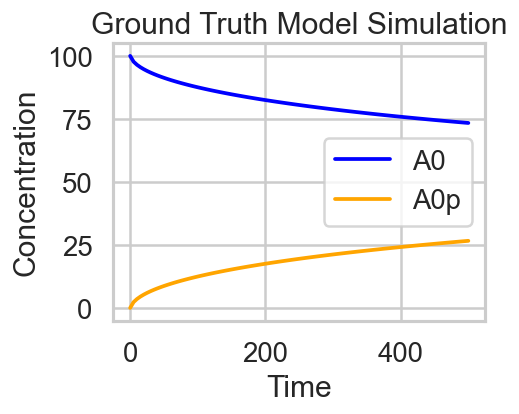

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(4, 3), dpi=120)

# plot only A0 and A0p 
plt.plot(results['time'], results['A0'], label='A0', color='blue')
plt.plot(results['time'], results['A0p'], label='A0p', color='orange')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Ground Truth Model Simulation')
plt.legend()
plt.show()
plt.close()


Understanding how km and vmax affect the reaction rates: modify J1 param

Parameters to keep: ['J1_Km', 'J1_Vmax']


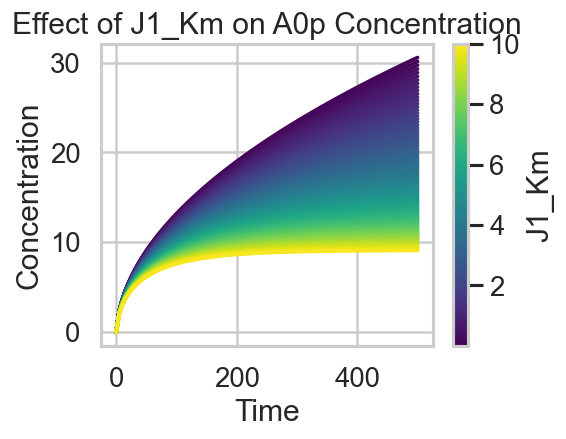

In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

J1_params = [key for key in params if 'J1' in key]
print(f'Parameters to keep: {J1_params}')

xs = np.linspace(0.01, 10, 100)
color_gradient = sns.color_palette("viridis", len(xs))

fig, ax = plt.subplots(figsize=(5, 4), dpi=120)

for i, x in enumerate(xs):
    solver.set_parameter_values({'J1_Km': x})
    results = solver.simulate(0, 500, 100)
    ax.plot(results['time'], results['A0p'], color=color_gradient[i])

ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
ax.set_title('Effect of J1_Km on A0p Concentration')

# Colorbar setup
norm = Normalize(vmin=min(xs), vmax=max(xs))
sm = ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # Only needed in older versions

cbar = plt.colorbar(sm, ax=ax)  # <-- Explicitly link colorbar to the current axes
cbar.set_label('J1_Km')

plt.tight_layout()
plt.show()
plt.close()


Parameters to keep: ['J1_Km', 'J1_Vmax']


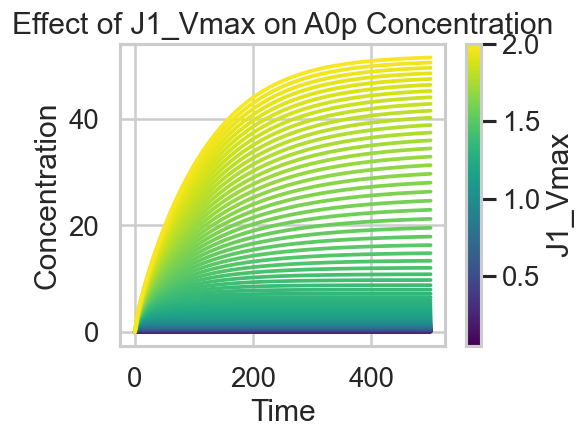

In [75]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

J1_params = [key for key in params if 'J1' in key]
print(f'Parameters to keep: {J1_params}')

xs = np.linspace(0.05, 2, 100)
color_gradient = sns.color_palette("viridis", len(xs))

fig, ax = plt.subplots(figsize=(5, 4), dpi=120)

for i, x in enumerate(xs):
    solver.set_parameter_values({'J1_Km': 50})
    solver.set_parameter_values({'J1_Vmax': x})
    results = solver.simulate(0, 500, 100)
    ax.plot(results['time'], results['A0p'], color=color_gradient[i])

ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
ax.set_title('Effect of J1_Vmax on A0p Concentration')

# Colorbar setup
norm = Normalize(vmin=min(xs), vmax=max(xs))
sm = ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # Only needed in older versions

cbar = plt.colorbar(sm, ax=ax)  # <-- Explicitly link colorbar to the current axes
cbar.set_label('J1_Vmax')

plt.tight_layout()
plt.show()
plt.close()


A perfect Michaelis-Menten curve is characterized by a high Km and a low Vmax shape